In [2]:
import numpy as np
import pandas as pd
import h5py
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import requests
from PIL import Image
import io


In [3]:
h5f = h5py.File('ckp/images_resized_embd.h5', 'r')
train_embeddings = h5f['image_embeddings'][:]

In [5]:
# load images_resized_sorted:
images = pd.read_csv('index/images_resized_sorted.csv')

links = pd.read_csv('inditextech_hackupc_challenge_images.csv')

In [6]:
def get_image(image_name):
    row, col = image_name.split('_')[0:2]

    image_url = links.iloc[int(row), int(col)]
    
    try:
        response = requests.get(image_url)
        if response.status_code == 200:
            # image = Image.open(io.BytesIO(response.content))
            import matplotlib.pyplot as plt
            # Convert response.content to image
            image = Image.open(io.BytesIO(response.content))

            return image

        else:
            print(f"Failed to download: {image_name}")
            get_image(image_name)  # Retry download
    
    except Exception as e:
        print(f"Error downloading {image_name}: {str(e)}")


In [7]:
def get_nearest_products(path, num_options=3):
    
    path_index = images[images['path'] == path].index[0]

    product_row = images[images['path'] == path]['row'].values[0]
    
    new_embedding = train_embeddings[path_index]
    k = 3 * num_options + 1

    similarities = np.array([cosine(new_embedding, emb) for emb in train_embeddings])
    
    k_lowest_values_indices = np.argsort(similarities)[:k]
    

    viewed_rows = []
    nearest_images = []
    
    for idx in k_lowest_values_indices:
        if images.loc[idx, 'row'] in viewed_rows + [product_row]:
            continue

        nearest_images.append(images.loc[idx, 'path'])
        viewed_rows.append(images.loc[idx, 'row'])

    return nearest_images[:num_options]

In [8]:
def show_product_neighbours(product):
    product_paths = [product] + get_nearest_products(product, 3)

    fig, axes = plt.subplots(1, len(product_paths), figsize=(15, 5))

    for i, path in enumerate(product_paths):
        axes[i].imshow(get_image(path))
        axes[i].axis('off')

    plt.show()

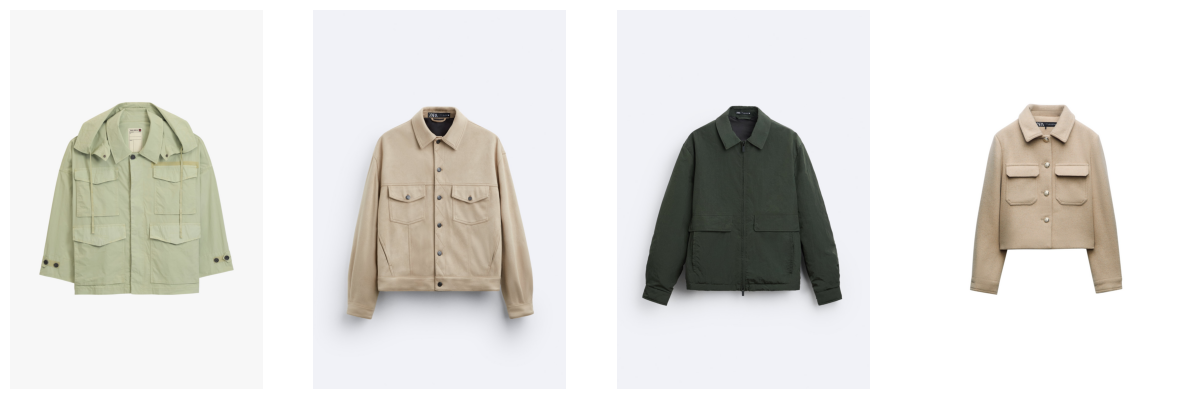

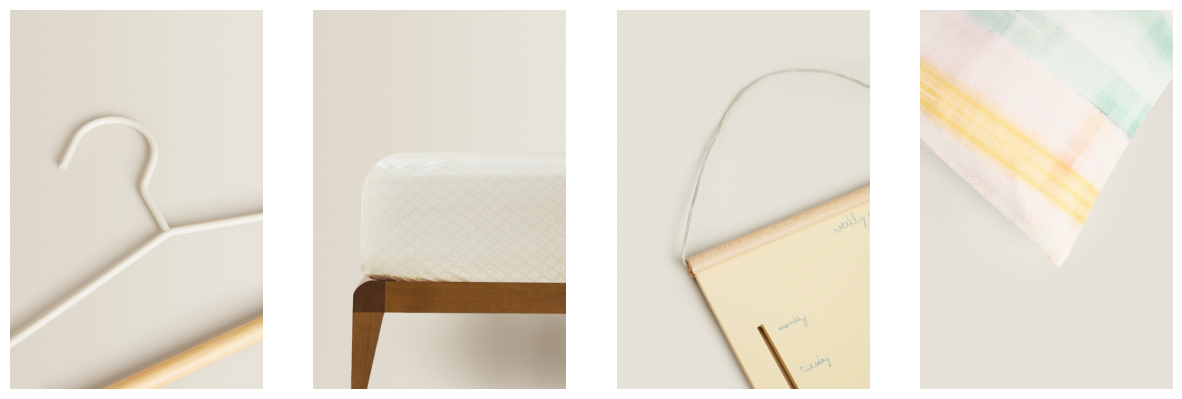

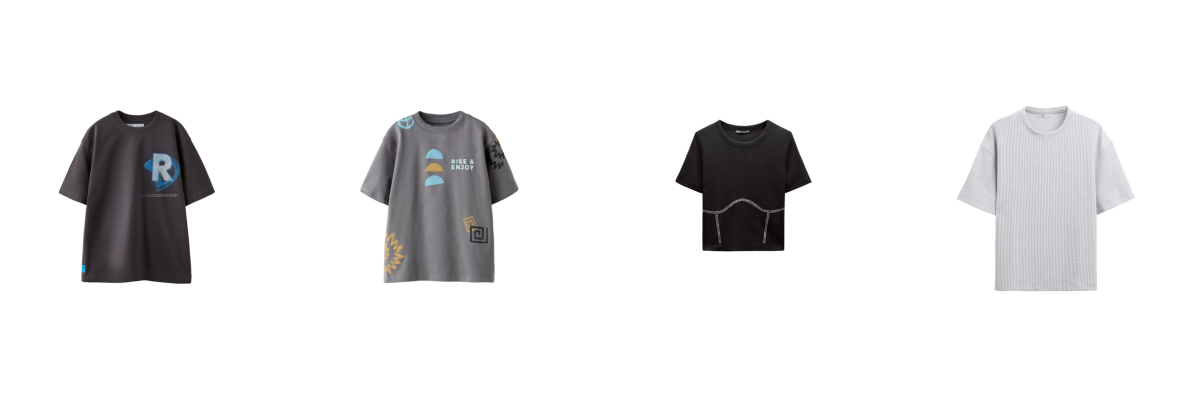

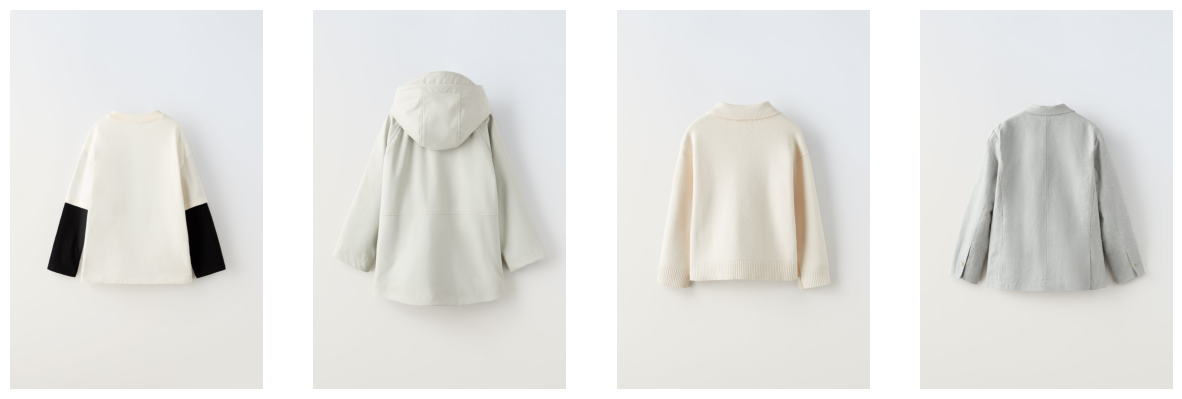

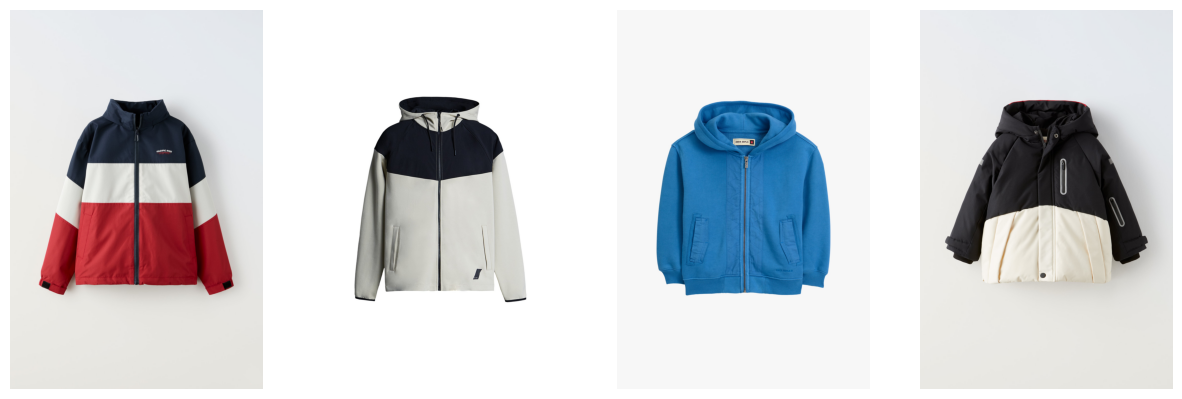

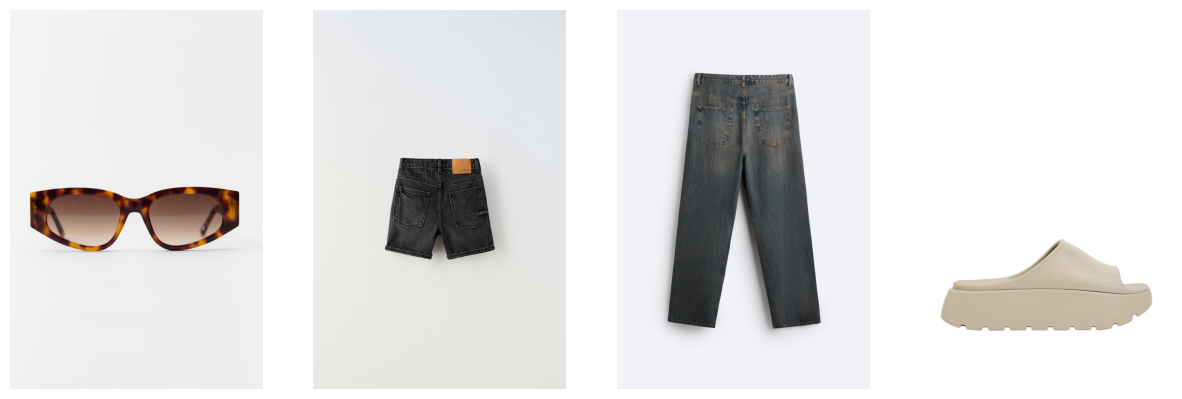

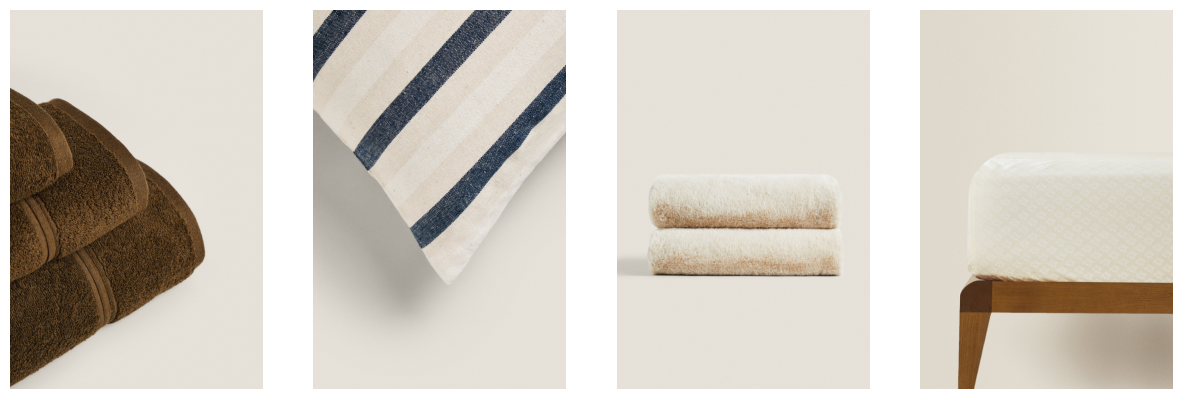

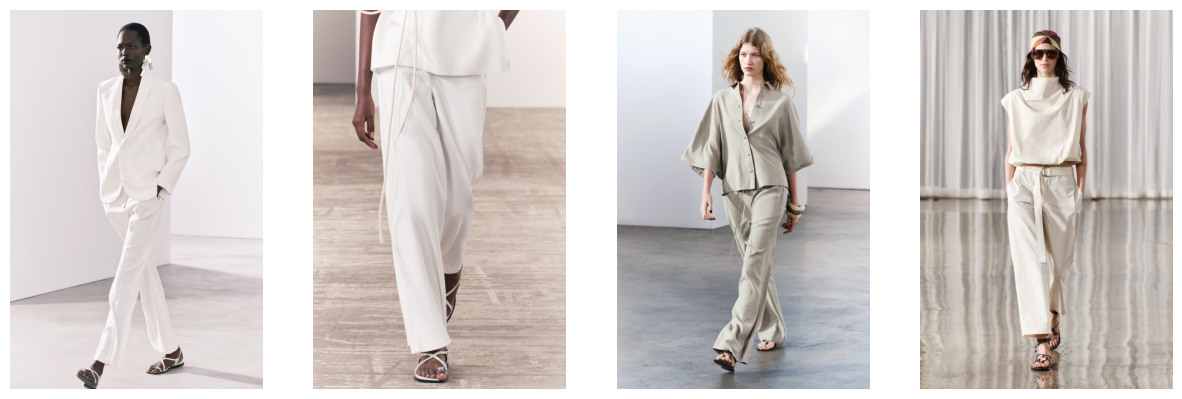

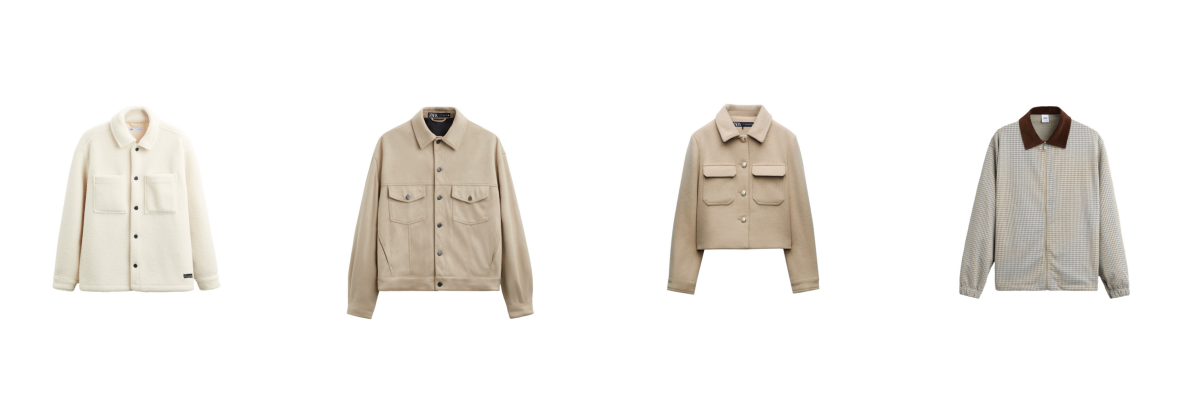

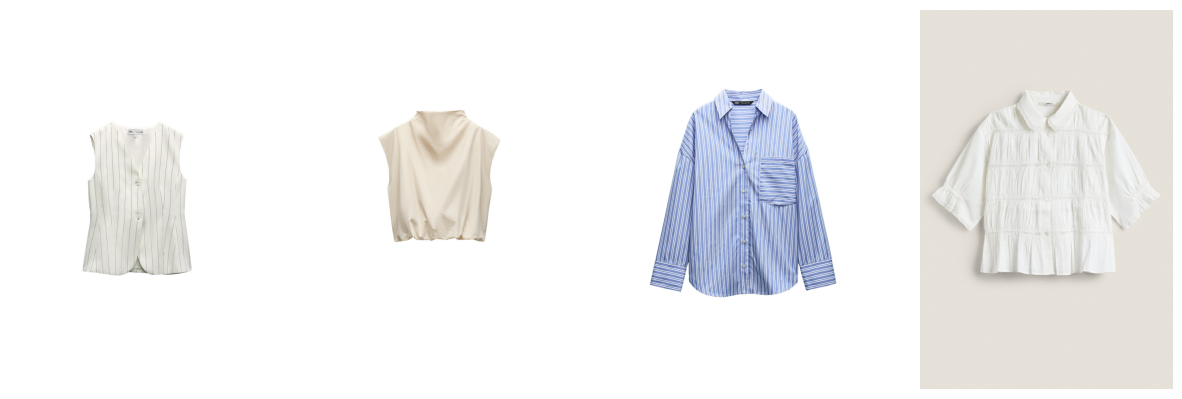

In [9]:
random_sample = images['path'].sample(n=10)
products = images['path']

for product in random_sample:
    show_product_neighbours(product)

In [10]:
def find_similar_products(new_embedding, num_options=3):
        
        k = 3 * num_options + 1
    
        similarities = np.array([cosine(new_embedding, emb) for emb in train_embeddings])
        
        k_lowest_values_indices = np.argsort(similarities)[:k]
    
        prev_row = -1
        nearest_images = []
        
        for idx in k_lowest_values_indices:
            if images.loc[idx, 'row'] == prev_row:
                continue
    
            nearest_images.append(images.loc[idx, 'path'])
            prev_row = images.loc[idx, 'row']
    
        return nearest_images[:num_options]

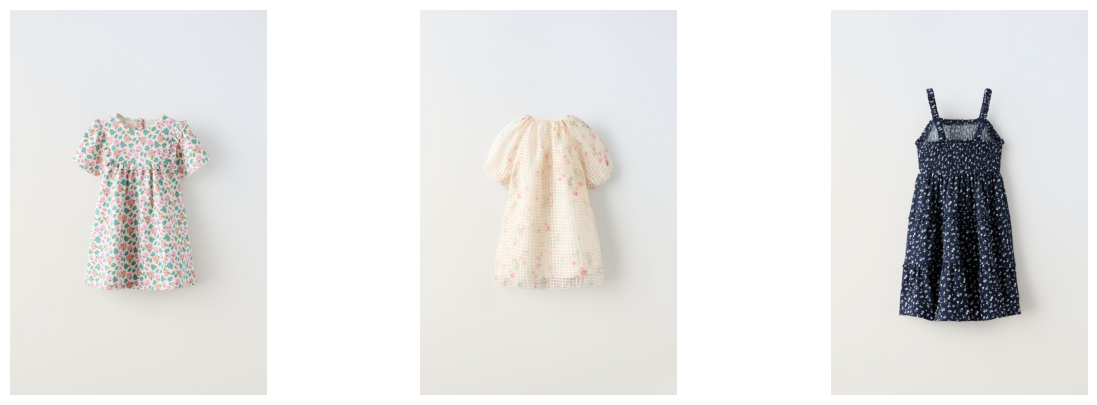

In [11]:
new_embedding = train_embeddings[0]

product_paths = find_similar_products(new_embedding, 3)

fig, axes = plt.subplots(1, len(product_paths), figsize=(15, 5))

for i, path in enumerate(product_paths):
    axes[i].imshow(get_image(path))
    axes[i].axis('off')

plt.show()